<a href="https://colab.research.google.com/github/nuriamontala/PYT-SBI/blob/main/PYT_SBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#CODE 20/02/2025
import torch
from torch_geometric.data import Data
import numpy as np
from Bio import PDB

# List of standard amino acids
AMINO_ACIDS = [
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE",
    "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"
]

# Generate one-hot encoding dictionary
AA_ONE_HOT = {aa: np.eye(len(AMINO_ACIDS))[i] for i, aa in enumerate(AMINO_ACIDS)}

# Physicochemical properties + One-Hot encoding
AA_PROPERTIES = {
    aa: [hydrophobic, polarity, charge] + list(AA_ONE_HOT[aa])
    for aa, (hydrophobic, polarity, charge) in {
        "ALA": [1, 0, 0], "ARG": [0, 1, 1], "ASN": [0, 1, 0], "ASP": [0, 1, -1], "CYS": [1, 0, 0],
        "GLN": [0, 1, 0], "GLU": [0, 1, -1], "GLY": [1, 0, 0], "HIS": [0, 1, 1], "ILE": [1, 0, 0],
        "LEU": [1, 0, 0], "LYS": [0, 1, 1], "MET": [1, 0, 0], "PHE": [1, 0, 0], "PRO": [1, 0, 0],
        "SER": [0, 1, 0], "THR": [0, 1, 0], "TRP": [1, 0, 0], "TYR": [1, 0, 0], "VAL": [1, 0, 0]
    }.items()
}

def parse_pdb_with_sites(pdb_file):
    """
    Parses a PDB file to extract:
    - ATOM lines: Standard protein atoms (non-binding site)
    - SITE lines: Atoms that belong to a binding site
    Returns dictionaries for atom positions and site labels.
    """
    atom_positions = {}  # Stores residue positions
    site_residues = set()  # Stores binding site residues

    with open(pdb_file, "r") as file:
        for line in file:
            if line.startswith("SITE") or line.startswith("ATOM"):
                try:
                    chain_id = line[21]  # Chain ID

                    # Extract and clean residue sequence number
                    res_id_str = line[22:26].strip()  # Residue ID (can have letters)
                    res_id = int(''.join(filter(str.isdigit, res_id_str)))  # Keep only numbers

                    atom_name = line[12:16].strip()  # Atom name (e.g., "CA")

                    # Extract and clean XYZ coordinates (ensure fixed-width parsing)
                    x = float(line[30:38].strip())
                    y = float(line[38:46].strip())
                    z = float(line[46:54].strip())

                    # Use only C-alpha atoms for residue positioning
                    if atom_name == "CA":
                        atom_positions[(chain_id, res_id)] = np.array([x, y, z])

                    # If SITE record, mark it as a binding site
                    if line.startswith("SITE"):
                        site_residues.add((chain_id, res_id))

                except ValueError as e:
                    print(f"Skipping line due to error: {line.strip()} - {e}")

    return atom_positions, site_residues



def compute_edges(residue_positions, cutoff=8.0):
    """
    Computes edges between residues based on Cα atom distances.
    """
    edges = []
    residue_ids = list(residue_positions.keys())
    coords = np.array([residue_positions[rid] for rid in residue_ids])

    for i in range(len(residue_ids)):
        for j in range(i + 1, len(residue_ids)):  # Avoid duplicate pairs
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= cutoff:
                edges.append((residue_ids[i], residue_ids[j]))

    return edges

def create_protein_graph(pdb_file):
    """
    Creates a PyTorch Geometric graph for an entire protein.
    Each node represents a residue with features:
    - Hydrophobicity
    - Polarity
    - Charge
    - Binding site category (only during training, ignored for inference)
    """
    atom_positions, site_residues = parse_pdb_with_sites(pdb_file)

    residue_features = []
    residue_labels = {}  # Stores binding site labels
    residue_names = []   # Stores residue names (ordered by node index)

    for res_id in atom_positions.keys():
        chain_id, residue_num = res_id

        # ✅ Instead of forcing labels to 0, set them to -1 if unknown (for inference)
        binding_label = 1 if res_id in site_residues else -1
        residue_labels[res_id] = binding_label  # Use -1 for unknown binding sites

        # Get residue properties (hydrophobicity, polarity, charge)
        aa_name = "UNK"  # Default unknown
        features = AA_PROPERTIES.get(aa_name, [0, 0, 0])  # Default to neutral
        residue_features.append(features)

        residue_names.append(aa_name)  # Store residue name

    # Convert binding site labels to tensor format (use -1 for unknown labels)
    node_labels = torch.tensor(
        [residue_labels.get(rid, -1) for rid in atom_positions.keys()], dtype=torch.float
    )

    # Compute edges
    edges = compute_edges(atom_positions)
    residue_index = {rid: i for i, rid in enumerate(atom_positions.keys())}
    edge_index = torch.tensor([[residue_index[r1], residue_index[r2]] for r1, r2 in edges]).t()

    # Convert features to tensor
    node_features = torch.tensor(residue_features, dtype=torch.float)

    return Data(x=node_features, edge_index=edge_index, y=node_labels), residue_index, residue_names



In [ ]:
import pandas as pd
from tabulate import tabulate

def print_node_info(protein_graph, residue_index, residue_names, node_idx):
    """
    Pretty prints the feature and connectivity information for a specific node in the protein graph.

    :param protein_graph: PyTorch Geometric Data object
    :param residue_index: Dictionary mapping (chain_id, res_id) -> node index
    :param residue_names: List storing amino acid names indexed by node index
    :param node_idx: Index of the node (residue) to inspect
    """
    # Get feature vector for the node
    node_features = protein_graph.x[node_idx].tolist()

    # Extract residue metadata
    index_to_residue = {v: k for k, v in residue_index.items()}  # Reverse mapping
    chain_id, res_id = index_to_residue[node_idx]  # Get chain & position
    residue_name = residue_names[node_idx]  # Residue name

    # Extract different feature components
    hydrophobicity, polarity, charge = node_features[:3]
    one_hot_encoding = node_features[3:-1]  # All but last (one-hot encoded amino acids)
    binding_site = node_features[-1]  # Last feature is binding site category

    # Get neighbors (connected nodes)
    connected_nodes = protein_graph.edge_index[1][protein_graph.edge_index[0] == node_idx].tolist()

    # Prepare DataFrame for better visualization
    feature_names = ["Hydrophobicity", "Polarity", "Charge"] + AMINO_ACIDS + ["Binding Site Category"]
    feature_values = [hydrophobicity, polarity, charge] + one_hot_encoding + [binding_site]

    df = pd.DataFrame({"Feature": feature_names, "Value": feature_values})

    print(f"\n=== Residue Information for Node {node_idx} ===")
    print(f"Residue: {residue_name}  |  Chain: {chain_id}  |  Position: {res_id}")
    print("\nResidue Properties:\n")
    print(tabulate(df, headers="keys", tablefmt="fancy_grid"))

    print(f"\n🔗 Connected Residues (Neighbors): {connected_nodes}")

# Example Usage
node_index = 5  # Choose a node to inspect
print_node_info(protein_graph, residue_index, residue_names, node_index)




=== Residue Information for Node 5 ===
Residue: ILE  |  Chain: A  |  Position: 6

Residue Properties:

╒════╤═══════════════════════╤═════════╕
│    │ Feature               │   Value │
╞════╪═══════════════════════╪═════════╡
│  0 │ Hydrophobicity        │       1 │
├────┼───────────────────────┼─────────┤
│  1 │ Polarity              │       0 │
├────┼───────────────────────┼─────────┤
│  2 │ Charge                │       0 │
├────┼───────────────────────┼─────────┤
│  3 │ ALA                   │       0 │
├────┼───────────────────────┼─────────┤
│  4 │ ARG                   │       0 │
├────┼───────────────────────┼─────────┤
│  5 │ ASN                   │       0 │
├────┼───────────────────────┼─────────┤
│  6 │ ASP                   │       0 │
├────┼───────────────────────┼─────────┤
│  7 │ CYS                   │       0 │
├────┼───────────────────────┼─────────┤
│  8 │ GLN                   │       0 │
├────┼───────────────────────┼─────────┤
│  9 │ GLU                   │     

In [16]:
#pdb_file = "1uv6.pdb"
#protein_graph, _, _ = create_protein_graph(pdb_file) # Unpack the tuple to get the Data object

from torch_geometric.data import Dataset
class ProteinGraphDataset(Dataset):
    def __init__(self, pdb_files):
        super().__init__()
        self.pdb_files = pdb_files
        self.graphs = []

        for pdb_file in pdb_files:
            try:
                graph = create_protein_graph(pdb_file)[0]  # Extract Data object
                self.graphs.append(graph)
                print(f"✅ Successfully processed {pdb_file}")
            except Exception as e:
                print(f"❌ Error processing {pdb_file}: {e}")  # Catch and print errors

    def len(self):
        return len(self.graphs)  # Number of graphs

    def get(self, idx):
        return self.graphs[idx]  # Return a specific graph


# Example usage

import os

# Define the directory where PDB files are stored
pdb_directory = "/content/proteins_extracted/protwithsite"  # Change this to your actual path

# Get all files with .pdb or .ent extension in the folder
pdb_files = [os.path.join(pdb_directory, f) for f in os.listdir(pdb_directory) if f.endswith((".pdb", ".ent"))]

# Create the dataset
dataset = ProteinGraphDataset(pdb_files)

print(f"Successfully loaded {len(dataset)} graphs.")


#print(protein_graph)
#print("Feature Matrix Shape:", protein_graph.x.shape)
#print("Number of Nodes:", protein_graph.x.shape[0])
#print("Number of Edges:", protein_graph.edge_index.shape[1])


✅ Successfully processed /content/proteins_extracted/protwithsite/4gkm_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/5aba_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/4ivc_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/1eby_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/2c3i_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/3ge7_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/2weg_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/4j28_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/1q8t_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/2j78_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/2yfe_protwithsite.pdb
✅ Successfully processed /conten

In [ ]:
pdb_file = "pdb3lb5.ent"
protein_graph, _, _ = create_protein_graph(pdb_file) # Unpack the tuple to get the Data object

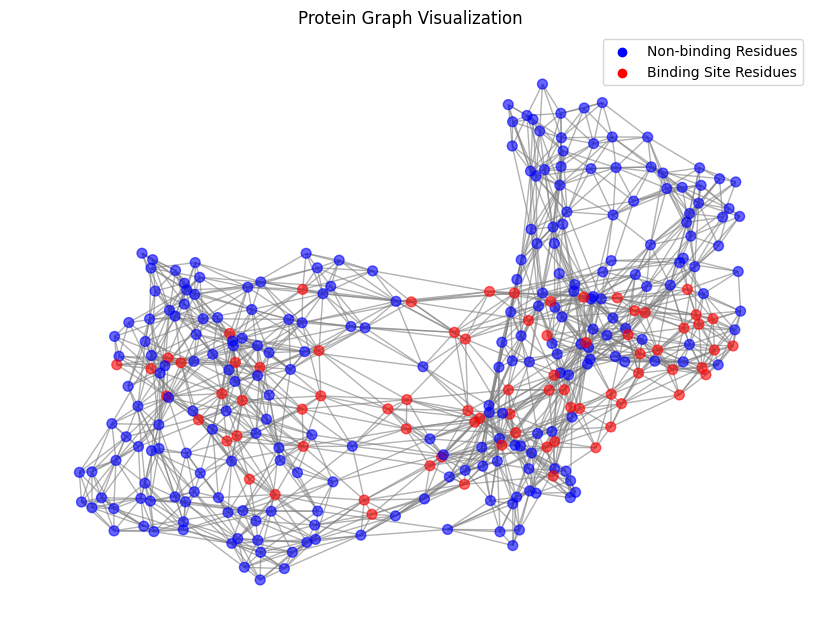

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_protein_graph(protein_graph, title="Protein Graph Visualization"):
    """
    Visualizes the protein graph using NetworkX and Matplotlib.
    Nodes are colored based on binding site labels.
    """
    # Convert PyTorch Geometric graph to NetworkX
    G = to_networkx(protein_graph, to_undirected=True)

    # Get node positions using a force-directed layout
    pos = nx.spring_layout(G, seed=42)

    # Extract binding site information from the node feature matrix
    binding_site_labels = protein_graph.y.numpy()

    # Define node colors:
    # - Non-binding residues (0) are blue
    # - Binding site residues (any other ID) are red
    node_colors = ["red" if label > 0 else "blue" for label in binding_site_labels]

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.6)

    # Legend
    plt.scatter([], [], color="blue", label="Non-binding Residues")
    plt.scatter([], [], color="red", label="Binding Site Residues")
    plt.legend(loc="upper right")

    plt.title(title)
    plt.show()

# Call the function to visualize the graph
visualize_protein_graph(protein_graph)


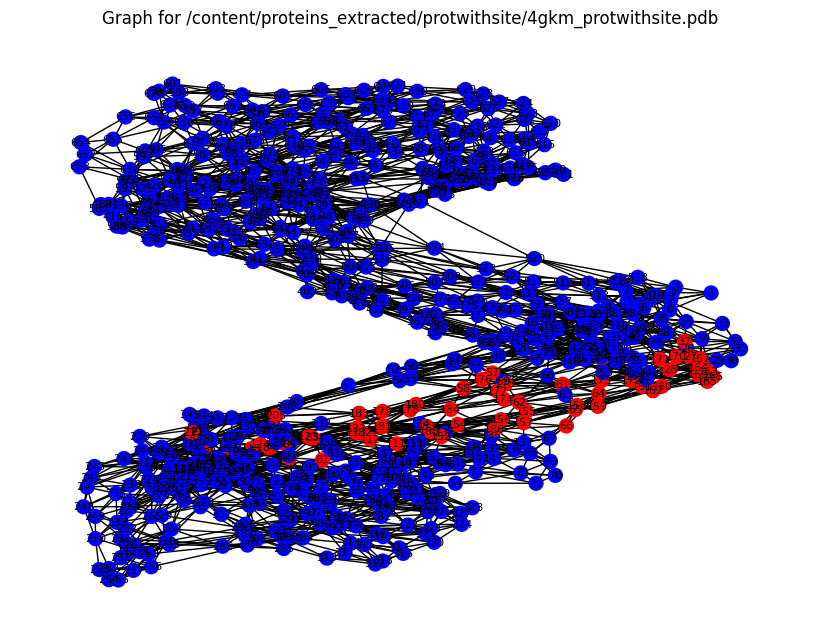

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x79b982edccc0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x79b982ea2660> (for post_execute):


KeyboardInterrupt: 

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(graph, title="Protein Graph"):
    """
    Converts a PyTorch Geometric graph to a networkx graph and plots it.
    Nodes are colored based on their binding site category.
    """
    G = to_networkx(graph, to_undirected=True)  # Convert to networkx
    plt.figure(figsize=(8, 6))

    # Node colors based on binding site category
    node_labels = graph.y.numpy()
    node_colors = ["red" if lbl > 0 else "blue" for lbl in node_labels]  # Binding sites = red

    nx.draw(G, with_labels=True, node_color=node_colors, node_size=100, font_size=8)
    plt.title(title)
    plt.show()

# Visualize the first graph in the dataset
visualize_graph(dataset.get(0), title=f"Graph for {dataset.pdb_files[0]}")

num_graphs = len(dataset)
cols = 3  # Set columns for the grid
rows = (num_graphs // cols) + (num_graphs % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

for i, graph in enumerate(dataset):
    row, col = divmod(i, cols)
    ax = axes[row, col]

    G = to_networkx(graph, to_undirected=True)
    node_labels = graph.y.numpy()
    node_colors = ["red" if lbl > 0 else "blue" for lbl in node_labels]

    nx.draw(G, ax=ax, node_color=node_colors, node_size=100, font_size=6)
    ax.set_title(f"Graph {i+1}: {dataset.pdb_files[i]}")

# Hide empty subplots if dataset size < rows*cols
for j in range(i + 1, rows * cols):
    row, col = divmod(j, cols)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.loader import DataLoader


class BindingSiteGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads=3):
        super(BindingSiteGNN, self).__init__()

        # First GNN layer: Graph Attention (GAT) or Graph Convolution (GCN)
        self.conv1 = GATConv(in_dim, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, concat=False)

        # Fully connected layers for final classification
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim // 2, out_dim)

    def forward(self, x, edge_index):
        # Graph attention/convolution layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Fully connected layers for classification
        x = self.fc1(x)
        x = self.dropout(F.relu(x))
        x = self.fc2(x)
        return torch.sigmoid(x)  # Output binding probability

# Training Function
def train_model(model, train_loader, num_epochs=20, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()  # Binary classification loss

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch.x, batch.edge_index).squeeze()
            loss = criterion(output, (batch.y > 0).float())  # Convert all non-zero values to 1
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")
    return model

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            output = model(batch.x, batch.edge_index).squeeze()
            predicted = (output > 0.5).float()
            correct += (predicted == batch.y).sum().item()
            total += batch.y.size(0)
    print(f"Accuracy: {correct / total:.2f}")


# Split dataset into training and testing (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create PyTorch Geometric DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Adjust batch_size as needed
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Create and train the model
in_dim = protein_graph.x.shape[1]  # Automatically get correct input size
model = BindingSiteGNN(in_dim=in_dim, hidden_dim=64, out_dim=1)
trained_model = train_model(model, train_loader)

# Evaluate the model
evaluate_model(trained_model, test_loader)


Epoch 1, Loss: 0.2630
Epoch 2, Loss: 0.1999
Epoch 3, Loss: 0.2011
Epoch 4, Loss: 0.2001
Epoch 5, Loss: 0.2005
Epoch 6, Loss: 0.1929
Epoch 7, Loss: 0.1921
Epoch 8, Loss: 0.1966
Epoch 9, Loss: 0.1933
Epoch 10, Loss: 0.1978
Epoch 11, Loss: 0.1919
Epoch 12, Loss: 0.1882
Epoch 13, Loss: 0.1930
Epoch 14, Loss: 0.1893
Epoch 15, Loss: 0.1942
Epoch 16, Loss: 0.1891
Epoch 17, Loss: 0.1899
Epoch 18, Loss: 0.1902
Epoch 19, Loss: 0.1901
Epoch 20, Loss: 0.1883
Accuracy: 0.93


In [32]:
import networkx as nx

def predict_binding_sites(model, pdb_file):
    """
    Predicts binding sites for a given PDB file using a trained GNN model.
    """
    # Create graph without relying on existing SITE labels
    protein_graph, residue_index, residue_names = create_protein_graph(pdb_file)

    # Ensure the model is in evaluation mode
    model.eval()

    # Move data to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    protein_graph = protein_graph.to(device)

    # Get predictions
    with torch.no_grad():
        predictions = model(protein_graph.x, protein_graph.edge_index).squeeze()

    # Normalize predictions (convert logits to scores between 0-1)
    binding_scores = torch.sigmoid(predictions)

    # Collect results
    predicted_binding_sites = {
        res_id: float(binding_scores[i]) for i, res_id in enumerate(residue_index.keys())
    }

    return predicted_binding_sites


In [22]:
def predict_binding_sites(model, pdb_file, threshold=0.5):
    protein_graph, residue_index, residue_names = create_protein_graph(pdb_file)  # Unpack properly

    with torch.no_grad():
        scores = model(protein_graph.x, protein_graph.edge_index).squeeze()

    predicted_binding_sites = {
        list(residue_index.keys())[i]: scores[i].item()
        for i in range(len(scores)) if scores[i].item() > threshold
    }

    return predicted_binding_sites


In [33]:
pdb_path = "1a3n.pdb"

# Dynamically get input dimension
in_dim = protein_graph.x.shape[1]
model = BindingSiteGNN(in_dim=in_dim, hidden_dim=64, out_dim=1)

# Predict binding sites
predicted_binding_sites = predict_binding_sites(model, pdb_path)

print("Predicted Binding Sites:")
for (chain, res_id), score in predicted_binding_sites.items():
    print(f"Residue {res_id} in Chain {chain}: Binding Score = {score:.3f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (572x3 and 4x192)